In [1]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic, great_circle
import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn import preprocessing

from datetime import date
import matplotlib.pyplot as plt
import shap

In [2]:
df_train_full = pd.read_csv('df_train_full_Sendy.csv')
df_test = pd.read_csv('df_test_Sendy.csv')

In [3]:
df_train_full['time_pick'] = df_train_full['Pickup - Time'].str[0:2].str.replace(':', '').astype(int) + 12*df_train_full['Pickup - Time'].str.contains('PM').astype(int)
df_train_full[['Pickup - Time', 'time_pick']].head()

,Pickup - Time,time_pick
0,10:27:30 AM,10
1,11:44:09 AM,11
2,12:53:03 PM,24
3,9:43:06 AM,9
4,10:05:23 AM,10


In [4]:
df_train_full['speed'] = df_train_full['Distance (KM)']/(df_train_full['Time from Pickup to Arrival']/3600)
df_train_full['speed_osrm'] = df_train_full['Distance (KM)']/(df_train_full['dur_osrm_motor']/3600)
df_test['speed_osrm'] = df_test['Distance (KM)']/(df_test['dur_osrm_motor']/3600)

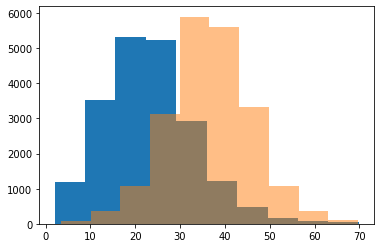

In [5]:
plt.hist(df_train_full['speed'][(df_train_full['speed'] < 70) & (df_train_full['speed'] > 2)])
plt.hist(df_train_full['speed_osrm'][(df_train_full['speed_osrm'] < 70) & (df_train_full['speed_osrm'] > 2)], alpha = 0.5)
plt.show()

In [6]:
df_test['time_pick'] = df_test['Pickup - Time'].str[0:2].str.replace(':', '').astype(int) + 12*df_test['Pickup - Time'].str.contains('PM').astype(int)
df_test[['Pickup - Time', 'time_pick']].head()

,Pickup - Time,time_pick
0,5:06:47 PM,17
1,1:25:37 PM,13
2,11:57:54 AM,11
3,2:16:52 PM,14
4,11:56:04 AM,11


In [7]:
df_train_full['ratio'] =  df_train_full['Time from Pickup to Arrival']/df_train_full['dur_osrm_motor']

In [ ]:
time_pick_ratios = df_train_full.groupby('time_pick')['ratio'].mean().reset_index()

In [ ]:
df_train_full = pd.merge(df_train_full, time_pick_ratios, how = 'left', on = 'time_pick')
df_test = pd.merge(df_test, time_pick_ratios, how = 'left', on = 'time_pick')

In [ ]:
df_train_full.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),...,User_33,User_34,User_35,User_36,dur_osrm_motor,time_pick,speed,speed_osrm,ratio_x,ratio_y
0,0,0,0,Order_No_4211,User_Id_633,0,2,0,9,5,...,1.0,0.0,0.0,0.0,318,10,19.328859,45.283019,2.342767,1.783738
1,1,1,1,Order_No_25375,0,0,2,1,12,5,...,0.0,0.0,0.0,0.0,1266,11,28.901154,45.497630,1.574250,1.942283
2,2,2,2,Order_No_1899,User_Id_265,0,2,0,30,2,...,0.0,0.0,0.0,0.0,378,24,23.736264,28.571429,1.203704,1.916077
3,3,3,3,Order_No_9336,0,0,2,0,15,5,...,0.0,0.0,0.0,0.0,669,9,24.161074,48.430493,2.004484,1.805356
4,4,4,4,Order_No_27883,0,0,0,1,13,1,...,0.0,0.0,0.0,0.0,736,10,26.688633,44.021739,1.649457,1.783738


In [ ]:
riders = pd.read_csv('Riders.csv')

In [ ]:
df_train_full = pd.merge(df_train_full, riders, how = 'left', on = 'Rider Id')
df_test = pd.merge(df_test, riders, how = 'left', on = 'Rider Id')

In [ ]:
for df_ in [df_train_full, df_test]:
    df_['Ord'] = df_['Order No'].str.replace('Order_No_', '').astype(int)

In [ ]:
df_train_full = df_train_full.sample(frac = 1)

In [ ]:
df_train, df_valid = df_train_full[:int(0.8*len(df_train_full))], df_train_full[int(0.8*len(df_train_full)):]

print('Train: ', len(df_train), '\nValid: ', len(df_valid),'\nTest: ',  len(df_test))

Train:  16960 
Valid:  4241 
Test:  7068


In [ ]:
def rmse(y_test, predictions):
    return np.sqrt(mean_squared_error(y_test, predictions))

In [ ]:
df_test.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Order No', 'User Id',
       'Vehicle Type', 'Platform Type', 'Personal or Business',
       'Placement - Day of Month', 'Placement - Weekday (Mo = 1)',
       ...
       'User_36', 'dur_osrm_motor', 'speed_osrm', 'time_pick', 'ratio',
       'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings', 'Ord'],
      dtype='object', length=206)

In [ ]:
df_train['dur_osrm_motor_adj'] = df_train['ratio_y'] * df_train['dur_osrm_motor']

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_valid['dur_osrm_motor_adj'] = df_valid['ratio_y'] * df_valid['dur_osrm_motor']

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_train_full['dur_osrm_motor_adj'] = df_train_full['ratio_y'] * df_train_full['dur_osrm_motor']

In [ ]:
df_test['dur_osrm_motor_adj'] = df_test['ratio'] * df_test['dur_osrm_motor']

In [ ]:
df_test.columns[:50]

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Order No', 'User Id',
       'Vehicle Type', 'Platform Type', 'Personal or Business',
       'Placement - Day of Month', 'Placement - Weekday (Mo = 1)',
       'Placement - Time', 'Confirmation - Day of Month',
       'Confirmation - Weekday (Mo = 1)', 'Confirmation - Time',
       'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Distance (KM)', 'Temperature', 'Precipitation in millimeters',
       'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Rider Id', 'dist_geo', 'dist_cir', 'time_place', 'time_confirm',
       'time_arr', 'time_pickup', 'diff_place', 'diff_arr', 'diff_pickup',
       'dur_osrm', 'diff_durs', 'rider_0', 'rider_1', 'rider_2', 'rider_3',
       'rider_4', 'rider_5', 'rider_6', 'rider_7', 'rider_8', 'rider_9',
       'rider_10'],
      dty

In [ ]:
list_feat = ['Personal or Business', 'Pickup - Weekday (Mo = 1)', 
            'Distance (KM)', 
            'dur_osrm_motor', 'speed_osrm', 'No_Of_Orders','Age',
             'Average_Rating',
             'time_pick', 'Ord', 'Destination Lat', 'Destination Long', 'Temperature',
            'Pickup Lat', 'Pickup Long', 'dist_geo', 'dist_cir', 'dur_osrm', 'Precipitation in millimeters', 'diff_lats',
            'diff_lons'] + \
list(df_test.columns[df_test.columns.str.contains('rider_')])

In [ ]:
df_train_full['speed'].describe(percentiles = [0.01, 0.99])

count    21201.000000
mean       249.305379
std       1905.297307
min          0.920245
1%           4.884668
50%         23.064602
99%       7200.000000
max      61200.000000
Name: speed, dtype: float64

In [ ]:
df_train = df_train[df_train['speed'] < 200]
df_train = df_train[df_train['speed'] > 0.5]

In [ ]:
df_train[list_feat + ['speed']].corr().iloc[-1]

Personal or Business           -0.032929
Pickup - Weekday (Mo = 1)      -0.013811
Distance (KM)                   0.281925
dur_osrm_motor                  0.231997
speed_osrm                      0.119960
No_Of_Orders                    0.010574
Age                            -0.036820
Average_Rating                  0.057108
time_pick                      -0.025893
Ord                             0.015260
Destination Lat                -0.009504
Destination Long                0.057285
Temperature                    -0.018446
Pickup Lat                     -0.037883
Pickup Long                     0.095268
dist_geo                        0.250747
dist_cir                        0.250716
dur_osrm                        0.251167
Precipitation in millimeters   -0.084503
diff_lats                      -0.018707
diff_lons                       0.018235
rider_0                        -0.004965
rider_1                         0.019216
rider_2                         0.002329
rider_3         

In [ ]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'learning_rate' : params['learning_rate'],
        'min_child_samples' : int(params['min_child_samples']),
        'feature_fraction' : params['feature_fraction'],
        'bagging_fraction' : params['bagging_fraction'],
        'lambda_l2' : params['lambda_l2'],
        'lambda_l1' : params['lambda_l1'],
        'n_estimators' :  int(params['n_estimators'])
    }    
    gbm = lgb.LGBMRegressor(
        min_data_per_group = 2,
        reg_sqrt = True,
        num_threads = 8,
        objective = 'mse',
        bagging_freq = 5,
        boost_from_average = True,
        seed = 42,
        categorical_features = [0, 1],
        **params
    )
    
    score = rmse(df_train['Time from Pickup to Arrival'], 
                 3600 * df_train['Distance (KM)'] / (cross_val_predict(gbm, df_train[list_feat].values, 
                                                                        ((df_train['speed'])), 
                                                                        cv = KFold(n_splits = 3, 
                                                                        random_state = 18, 
                                                                        shuffle=True))))

    print("RMSE {:.0f} params {}".format(score, params))
    return score

space = {
    'n_estimators' : hp.quniform('n_estimators', 10, 1000, 1),
    'learning_rate' : hp.quniform('learning_rate', 0.0001, 0.5, 0.0001),
    'min_child_samples' : hp.quniform('min_child_samples', 3, 300, 1),
    'num_leaves' : hp.quniform('num_leaves', 32, 128, 1),
    'feature_fraction' : hp.quniform('feature_fraction', 0.1, 1.0, 0.05),
    'bagging_fraction' : hp.quniform('bagging_fraction', 0.1, 1.0, 0.05),
    'lambda_l2' : hp.quniform('lambda_l2', 0.001, 0.5, 0.001),
    'lambda_l1' : hp.quniform('lambda_l1', 0.001, 0.5, 0.001)
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals = 50)

RMSE 783 params {'num_leaves': 56, 'learning_rate': 0.24880000000000002, 'min_child_samples': 229, 'feature_fraction': 0.30000000000000004, 'bagging_fraction': 0.15000000000000002, 'lambda_l2': 0.257, 'lambda_l1': 0.107, 'n_estimators': 205}
RMSE 858 params {'num_leaves': 35, 'learning_rate': 0.43, 'min_child_samples': 237, 'feature_fraction': 0.45, 'bagging_fraction': 0.8, 'lambda_l2': 0.362, 'lambda_l1': 0.047, 'n_estimators': 575}
RMSE 765 params {'num_leaves': 83, 'learning_rate': 0.026000000000000002, 'min_child_samples': 299, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0, 'lambda_l2': 0.215, 'lambda_l1': 0.045, 'n_estimators': 603}
RMSE 784 params {'num_leaves': 84, 'learning_rate': 0.3436, 'min_child_samples': 174, 'feature_fraction': 0.45, 'bagging_fraction': 0.4, 'lambda_l2': 0.13, 'lambda_l1': 0.221, 'n_estimators': 11}
RMSE 786 params {'num_leaves': 35, 'learning_rate': 0.30720000000000003, 'min_child_samples': 243, 'feature_fraction': 0.7000000000000001, '

RMSE 784 params {'num_leaves': 118, 'learning_rate': 0.0794, 'min_child_samples': 132, 'feature_fraction': 0.65, 'bagging_fraction': 0.65, 'lambda_l2': 0.497, 'lambda_l1': 0.059000000000000004, 'n_estimators': 654}
RMSE 772 params {'num_leaves': 107, 'learning_rate': 0.033800000000000004, 'min_child_samples': 55, 'feature_fraction': 0.4, 'bagging_fraction': 0.30000000000000004, 'lambda_l2': 0.395, 'lambda_l1': 0.353, 'n_estimators': 708}
RMSE 790 params {'num_leaves': 73, 'learning_rate': 0.18960000000000002, 'min_child_samples': 227, 'feature_fraction': 0.1, 'bagging_fraction': 0.8500000000000001, 'lambda_l2': 0.125, 'lambda_l1': 0.022, 'n_estimators': 786}
RMSE 766 params {'num_leaves': 99, 'learning_rate': 0.0158, 'min_child_samples': 170, 'feature_fraction': 0.9500000000000001, 'bagging_fraction': 0.75, 'lambda_l2': 0.217, 'lambda_l1': 0.193, 'n_estimators': 611}
RMSE 781 params {'num_leaves': 80, 'learning_rate': 0.11320000000000001, 'min_child_samples': 253, 'feature_fraction': 0

In [ ]:
best

{'bagging_fraction': 1.0,
 'feature_fraction': 0.6000000000000001,
 'lambda_l1': 0.045,
 'lambda_l2': 0.215,
 'learning_rate': 0.026000000000000002,
 'min_child_samples': 299.0,
 'n_estimators': 603.0,
 'num_leaves': 83.0}

In [ ]:
print("Hyperopt estimated optimum {}".format(best))

best = {
        'num_leaves': int(best['num_leaves']),
        'learning_rate' : best['learning_rate'],
        'min_child_samples' : int(best['min_child_samples']),
        'feature_fraction' : best['feature_fraction'],
        'bagging_fraction' : best['bagging_fraction'],
        'lambda_l2' : best['lambda_l2'],
        'lambda_l1' : best['lambda_l1'],
        'n_estimators' :  int(best['n_estimators'])
    }    

gbm2 = lgb.LGBMRegressor(
        min_data_per_group = 2,
        reg_sqrt = True,
        num_threads = 8,
        objective = 'mse',
        bagging_freq = 5,
        boost_from_average = True,
        seed = 42,
        categorical_features = [0, 1],
        **best
    )

Hyperopt estimated optimum {'bagging_fraction': 1.0, 'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.045, 'lambda_l2': 0.215, 'learning_rate': 0.026000000000000002, 'min_child_samples': 299.0, 'n_estimators': 603.0, 'num_leaves': 83.0}


In [ ]:
fitted = gbm2.fit(df_train[list_feat].values, (df_train['speed']))
df_valid['predict'] = 3600 * df_valid['Distance (KM)'] / ((fitted.predict(df_valid[list_feat].values)))
rmse_valid = np.round(rmse(df_valid['Time from Pickup to Arrival'], df_valid['predict']), 1)                           
print(rmse_valid.mean())

775.8


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
df_valid = df_valid[df_valid['speed'] < 200]
df_valid = df_valid[df_valid['speed'] > 0.5]
fitted = gbm2.fit(df_train[list_feat].values, (df_train['speed']))
df_valid['predict'] =  3600 * df_valid['Distance (KM)'] / ((fitted.predict(df_valid[list_feat].values)))
rmse_valid = np.round(rmse(df_valid['Time from Pickup to Arrival'], df_valid['predict']), 1)                           
print(rmse_valid.mean())

753.0


In [ ]:
df_train_full = df_train_full[df_train_full['speed'] < 200]
df_train_full = df_train_full[df_train_full['speed'] > 0.5]

In [ ]:
gbm2.fit(df_train_full[list_feat].values, (df_train_full['speed']))
df_test['Time from Pickup to Arrival'] = 3600 * df_test['Distance (KM)'] / (gbm2.predict(df_test[list_feat]))
df_test[['Order No', 'Time from Pickup to Arrival']].to_csv('sumbit_sendi_'+ str(date.today())+'_'+str(rmse_valid)+'.csv', index = False)

In [ ]:
explainer2 = shap.TreeExplainer(gbm2)
shap_values2 = explainer2.shap_values(df_train_full[list_feat])

In [ ]:
shap_gr2 = shap.summary_plot(shap_values2, df_train_full[list_feat], max_display=50)
plt.show()